# A demonstration of the autonomous decision making system

### The intent of this notebook is to demonstrate the use of a decision making system for the Nova Rover. In order to do this we need to: 
1. Simulate the rover's motion and detections in a simulated environment.
2. Simulate detected obstacles and targets
3. Demonstrate decision making system that avoids 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from itertools import product
from pathfinding.a_star import a_star_search
from utils.rover import Rover

Now that the class of the rover has been defined, we will implement an a* based pathfinding algorithm to search over the known grid. 
We begin by defining a grid that exists as the rovers main knowledge base. Called World ($W$)
Where, $W$ is a 2D array used to denote the "threat" or "opportunity" level of the grid square. All grid sqaures correspond to real world positions, each grid square has width $w$, which can be tuned for the application. 

Each cell has a value $W_{x,y} \in \mathbb{R}$ 

Lower values are an opportunity, Higher values are a threat. 
The algorithm for searching the space works as follows.
1. **Initialise** If the rover has just begun a new search for a target (could be a tennis ball) then initialise the array with the following. If this is not true skip this step. 
    1. Generate an array of zeros with height and width defined by the distance between the target and the rover as estimated by the rovers localization algorithm and the competition supplied gps coordinates. Ensure sufficient for overshoot. For example if it is $X$ m to the tennis ball and square width is defined as $w$ then $n = \frac{X}{w}$ is the height and width of the array. 
    2. Place a guassian function at the tennis ball gps location with amplitude $A = -1$ and each cell within range $3 \sigma$ from the centre calculate its value from that guassian. 
    


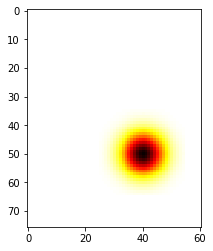

In [2]:
## Initialisation routine example in python. 

def norm_pdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

def apply_gaussian_to_field(field,weight,x,y,sigma):
    for i in range(y-3*sigma,y+3*sigma):            
        for j in range(x-3*sigma,x+3*sigma):
            
            cart_distance = math.sqrt((x-j)**2 +(y-i)**2)
            
            if i in set(range(0,field.shape[0])) and j in set(range(0, field.shape[1])):
                field[i,j] = weight* norm_pdf(cart_distance,0,sigma) + field[i,j] 
    return field


def initialise_tennis_ball_search(x=40,y=50):
    suspected_x, suspected_y = (x,y)
    rover_x, rover_y = (0,0)
    width = 1 # width of a grid cell = 0.1m (tuneable)
    sigma = 5 # standard deviation of the guassian
    fudge_factor =1.5 ## Tuneable!
    x_size = int (fudge_factor*(suspected_x-rover_x)+ 1)
    y_size = int (fudge_factor*(suspected_y-rover_y)+ 1)
    rover_world = np.ones((y_size,x_size))
    
    rover_world = apply_gaussian_to_field(rover_world,-20.0,suspected_x,suspected_y,5)
    return rover_world


arr = initialise_tennis_ball_search()
plt.imshow(arr, cmap='hot', interpolation='nearest')
plt.show()

This is what the rover will know about the world when it first starts up, it will identify the cell of highest interest (Lowest cell index value) and use a minimum cost pathfinding approach
2. **Remap** the rover will scan the environment with its sensors and re update the map using its current estimates. 
    1. Detect any obstacles and/or opportunities with a certain confidence level $p$ and with a certain confidence on the localisation $\sigma_ij$. 
    2. Update the _RoverWorld_ map with the targets and opportunities, scaling them appropriately based on cost. 
3. **Pathfind** Once the map has been updated, recompute the path forward using the new information. 
4. **Move** and iterate the process. 


In [3]:
# Defining obstacles notation size x position y position sigma
obstacles = [(100,20,20,5),(100,20,40,5),(200,40,20,10)]


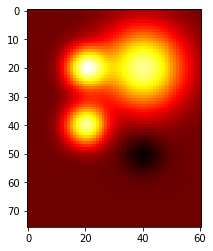

In [4]:
for obstacle in obstacles:
    arr = apply_gaussian_to_field(arr,*obstacle)
    
plt.imshow(arr, cmap='hot', interpolation='nearest')
plt.show()

This is an example of how the world will hopefully look from the perspective of the Rover while it is navigating. The remaining task is to pathfind over that graph. We will use the astar algorithm developed by MSP for the 2018 rover to accomplish this. See code below (however, the datails are not super relevant for our purposes here). 

Before anything else we need to select an objective of the rover, for simplicity we will use the minimum of the graph, something more complex (intelligent) could concievably be used though. 

In [5]:
from pathfinding.a_star import a_star_search
from pathfinding.best_first import best_first_search
from pathfinding.dijkstra import dijkstra_search

In [6]:
min_index_y, min_index_x = np.argwhere(arr == np.min(arr))[0]
path = a_star_search(arr,(0,0),(min_index_x, min_index_y))

We now have a path from the beginning point (0,0) to the end target point (50,50). For simplicity we are assuming that the target is exactly at the place where it is most likely to be. Obviously this does not reflect reality, but we will build to that. The next step is to superimpose the path onto a plot of the grid of threats and opportunities to show that it is navigating appropriately. 

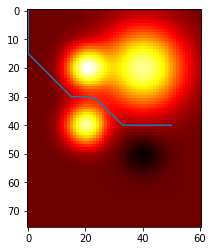

In [12]:
x_pos = []
y_pos = []
for x, y in path:
    x_pos.append(x)
    y_pos.append(y)
plt.plot(y_pos,x_pos)
plt.imshow(arr, cmap='hot', interpolation='nearest')
plt.show()


Now that we have tackled the problem of searching over a known field we need to address the more pressing challenge. Pathfinding over a unknown field. As described above, the strategy will be to update the map that we are pathfinding over, and then run a* on that. For simplicity we will simply say that the rover takes the next position identified by the a star pathfinding algorithm, and then rescans the environment and repeats the process.

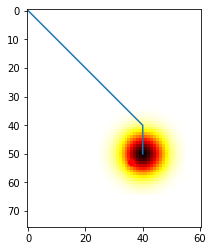

In [8]:
rover_init_postion = (0,0)
ball_location = (36,53) # The actual position of the ball. 
rover_world = initialise_tennis_ball_search()

plt.imshow(rover_world, cmap='hot', interpolation='nearest')
min_index_y, min_index_x = np.argwhere(rover_world == np.min(rover_world))[0]
path_new = a_star_search(rover_world,(0,0),(min_index_x, min_index_y))
x_pos = []
y_pos = []
for x, y in path_new:
    x_pos.append(x)
    y_pos.append(y)
plt.plot(x_pos,y_pos)
plt.plot(ball_location[0],ball_location[1],"ro")
plt.show()


This the first step in the loop, the red dot on the graph represents the actual position of the tennis ball. To make things more challenging we will add 50 obstacles dotted throughout the region, generated randomly.

We then need to simulate the detection of these obstacles and targets. 

To do this we will use either random or user generated obstacle lists, when the rover is within a certain range of these obstacles the rover adds them to the map. A similar thing happens with the tennis ball, when it is within range the location of the tennis ball is set to be a place of high interest that the rover can navigate to. 

Randomly generating obstacles can be done but they wont necessarily get placed anywhere interesting, so the use can choose to drop them exactly in the path of the rover and then re run the notebook. This leads to more interesting behaviour. 

In [9]:
import random 
random.seed()
# unknown_obstacles = [ ( random.randint(0, 60), random.randint(0, 60) ) for k in range(10) ]
unknown_obstacles = [(7,40)]
unknown = set(unknown_obstacles)

rover_loc = rover_init_postion
def scan(known,obs,pos, ten_loc):
    pos_x, pos_y = pos
    rge = [-3,-2,-1,0,1,2,3]
    n_rows = len(known)
    n_cols = len(known[0])   
    reach = [(pos_x + dx, pos_y + dy) for dx, dy in product(rge,rge)]
    for x, y in reach:

        if (x,y) in obs:
            return apply_gaussian_to_field(known,20,x,y,5)
        elif (x,y) == ten_loc:
            return apply_gaussian_to_field(known,-70,x,y,5)
    
    return known

path = [rover_loc]

We will also add back the obstacles from the earlier sections to the rover map. We will tell the rover about these obstacles ahead of time, we can imagine these as simulating no-go zones that the rover will avoid based on satellite imagery analysis of the competition area.  

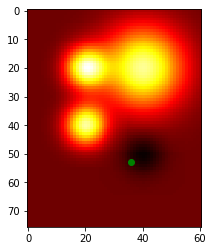

In [10]:
for obstacle in obstacles:
    rover_world = apply_gaussian_to_field(rover_world,*obstacle)

plt.imshow(rover_world, cmap='hot', interpolation='nearest')
plt.plot(ball_location[0],ball_location[1],"ro",color = "Green")
plt.show()

We can see the rovers initial understanding of the environment with the tennis ball position in green shown as well. The rover only has the rough estimate of the tennis ball position given from the rough guassian near it. It does not know the exact location of the tennis ball, only that it is most likely nearby. 

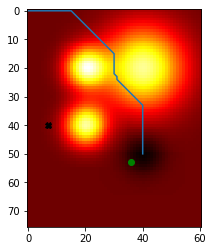

In [11]:
while rover_loc != ball_location:
    rover_world = scan(rover_world,unknown,rover_loc,ball_location)
    min_y, min_x = np.argwhere(rover_world == np.min(rover_world))[0]
    curr_path = a_star_search(rover_world,rover_loc,(min_x,min_y))

    if len(curr_path) == 1:
        break

    rover_loc = curr_path[1]
    path.append(rover_loc)
    
plt.imshow(rover_world, cmap='hot', interpolation='nearest')
plt.plot(ball_location[0],ball_location[1],"ro",color = "Green")
x_pos = []
y_pos = []
for ob in unknown_obstacles:
    plt.plot(ob[0],ob[1],"X",color="black")
for x, y in path:
    x_pos.append(x)
    y_pos.append(y)
plt.plot(x_pos,y_pos)
plt.show()

The path the rover took to reach the final tennis ball is shown in blue and any obstacles added to the field are in black crosses and the rovers final knowledge of the environment. 

We can see that one of the major remaining issues is that the search path does not priorities driving over regions of interest on the way to any given target. This can be addressed by adjusting the heuristic of the a* search algorithm. But that is beyond the scope of this demonstration. 

The purpose was to demonstrate a decision making process for the rover to navigate an environment that it has only partial information about. It assumes a robust target recognition, obstacle detection and robot localisation system.  These will need to be built in order to work.
